In [1]:
import logging
import os
import random
import sys
from collections import deque

In [14]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.contrib.slim as slim
from nets.mobilenet import mobilenet_v2

BATCH_SIZE = 32
IMAGE_SIZE = 224

checkpoint_name = './mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt'

tf.__version__

'1.15.0'

In [3]:
def set_random_seed():
    seed = random.randrange(2 ** 32 - 2)
    logging.info('Using random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed + 1)
    tf.set_random_seed(seed + 2)
    
set_random_seed()

In [4]:
from dataset_factory import ImageCollector, ImgInverNormalize
import matplotlib.pyplot as plt

In [5]:
dataset = ImageCollector("./ARVision Data", 1, 100, 32) # Real data
dataset.StartLoadData()

module name: dataset_factory
parent process: 1707
process id: 2581


In [6]:
real_data = dataset.getLoadedData()

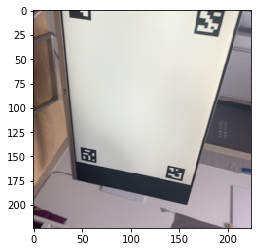

In [7]:
plt.imshow(ImgInverNormalize(real_data[1][0], 1.))
plt.show()

In [8]:
input_img = tf.placeholder(tf.float32, [BATCH_SIZE] + [IMAGE_SIZE, IMAGE_SIZE, 3])
input_label = tf.placeholder(tf.float32, [BATCH_SIZE] + [6])

In [9]:
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
    logits, endpoints = mobilenet_v2.mobilenet(input_img)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [12]:
saver = tf.train.Saver(tf.global_variables())

In [17]:
with tf.Session() as sess:
    real_data = dataset.getLoadedData()
    saver.restore(sess,  checkpoint_name)
    x = endpoints['Predictions'].eval(feed_dict={input_img: real_data[1]})

INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt
